# 🎬 Cinemate Recommendation System Pipeline
---
**Mục tiêu:** Xây dựng hệ thống gợi ý phim lai (Hybrid Recommender System) kết hợp giữa:
1.  **Collaborative Filtering (SVD):** Dựa trên lịch sử đánh giá của người dùng.
2.  **Content-Based Filtering (TF-IDF):** Dựa trên nội dung (cốt truyện, thể loại) của phim.

**Quy trình thực hiện:**
1.  Setup & Data Loading.
2.  Data Preprocessing.
3.  **Deep Exploratory Data Analysis (EDA):** Phân tích sâu, Heatmap, Tương quan.
4.  Model Training (SVD & TF-IDF).
5.  Model Evaluation & Export.

In [70]:
# 1.1 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import json
import warnings
from dotenv import load_dotenv
from sqlalchemy import create_engine
import scipy.sparse

# Scikit-learn & Surprise
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Reader, Dataset, SVD, accuracy, dump
from surprise.model_selection import train_test_split, GridSearchCV

# Cấu hình hiển thị
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore') # Ẩn các cảnh báo không cần thiết để notebook sạch đẹp

print(" Libraries imported successfully!")

 Libraries imported successfully!


In [71]:
# 1.2 Kết nối Database
load_dotenv()
DATABASE_URL = os.getenv('DATABASE_URL')

if not DATABASE_URL:
    raise ValueError(" DATABASE_URL not found in .env file.")

try:
    engine = create_engine(DATABASE_URL)
    print(" Database engine connected.")
except Exception as e:
    print(f" Connection failed: {e}")

 Database engine connected.


In [72]:
# 1.3 Load Data từ SQL
# Chúng ta cần load nhiều bảng để phục vụ cho việc phân tích sâu (EDA)
print("Loading data from database...")

# Load Ratings
query_ratings = 'SELECT "userId", "movieId", "score" FROM "Rating";'
ratings_df = pd.read_sql(query_ratings, engine)

# Load Movies (Kèm Genres và các thông tin quan trọng để phân tích)
query_movies = """
SELECT m.id, m.title, m.overview, m.release_date, 
       m.popularity, m.vote_average, m.vote_count,
       g.name as genre
FROM "Movie" m
LEFT JOIN "MovieGenre" mg ON m.id = mg."movieId"
LEFT JOIN "Genre" g ON mg."genreId" = g.id
"""
movies_raw_df = pd.read_sql(query_movies, engine)

print(f" Data Loaded:")
print(f"   - Ratings: {ratings_df.shape}")
print(f"   - Movies (Raw joined): {movies_raw_df.shape}")
print(f"   - Date range: {movies_raw_df['release_date'].min()} to {movies_raw_df['release_date'].max()}")

Loading data from database...
 Data Loaded:
   - Ratings: (100808, 3)
   - Movies (Raw joined): (22028, 8)
   - Date range: 1902-01-01 00:00:00 to 2023-03-22 00:00:00


## 2. Data Preprocessing
Bước này chuẩn hóa dữ liệu: chuyển đổi kiểu dữ liệu, xử lý giá trị thiếu và gộp dữ liệu để chuẩn bị cho phân tích.

In [73]:
# ============================================================================
# 2. DATA PREPROCESSING - PROFESSIONAL VERSION
# ============================================================================

import re

# 2.1 Chuẩn hóa kiểu dữ liệu
print("=" * 80)
print("2.1 CHUẨN HÓA KIỂU DỮ LIỆU")
print("=" * 80)
ratings_df['userId'] = ratings_df['userId'].astype(str)
ratings_df['movieId'] = ratings_df['movieId'].astype(int)
ratings_df['score'] = ratings_df['score'].astype(int)
print("✓ Đã chuẩn hóa kiểu dữ liệu cho ratings_df")

# 2.2 Xử lý bảng Movies (Gộp Genre lại thành 1 dòng cho mỗi phim)
print("\n" + "=" * 80)
print("2.2 XỬ LÝ BẢNG MOVIES")
print("=" * 80)
movies_processed = movies_raw_df.groupby('id').agg({
    'title': 'first',
    'overview': 'first',
    'release_date': 'first',
    'popularity': 'first',
    'vote_average': 'first',
    'vote_count': 'first',
    'genre': lambda x: ' '.join(x.dropna().astype(str)) if len(x.dropna()) > 0 else 'Unknown'
}).reset_index()
movies_processed.rename(columns={'genre': 'genres_str'}, inplace=True)

# Xử lý NULL cho overview
movies_processed['overview'] = movies_processed['overview'].fillna('no description available')
print("✓ Đã gộp genres và xử lý giá trị NULL")

# 2.3 LOẠI BỎ DỮ LIỆU NHIỄU (Noise Filtering) - QUAN TRỌNG!
print("\n" + "=" * 80)
print("2.3 LỌC DỮ LIỆU NHIỄU (Noise Filtering)")
print("=" * 80)

# Thiết lập ngưỡng lọc
min_movie_ratings = 10  # Phim phải có ít nhất 10 đánh giá
min_user_ratings = 5    # User phải đã đánh giá ít nhất 5 phim

print(f" Ngưỡng lọc:")
print(f"   - Phim tối thiểu: {min_movie_ratings} ratings")
print(f"   - User tối thiểu: {min_user_ratings} ratings")

# Lọc phim
filter_movies = ratings_df['movieId'].value_counts() >= min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

# Lọc người dùng
filter_users = ratings_df['userId'].value_counts() >= min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

# Tạo dataframe sạch
df_cleaned = ratings_df[ratings_df['movieId'].isin(filter_movies) & 
                        ratings_df['userId'].isin(filter_users)]

print(f"\n Kết quả lọc:")
print(f"   - Dữ liệu ban đầu: {len(ratings_df):,} ratings")
print(f"   - Dữ liệu sau khi lọc: {len(df_cleaned):,} ratings")
print(f"   - Đã loại bỏ: {len(ratings_df) - len(df_cleaned):,} ratings nhiễu ({(1 - len(df_cleaned)/len(ratings_df))*100:.2f}%)")
print(f"   - Movies còn lại: {df_cleaned['movieId'].nunique():,} / {ratings_df['movieId'].nunique():,}")
print(f"   - Users còn lại: {df_cleaned['userId'].nunique():,} / {ratings_df['userId'].nunique():,}")

# Cập nhật ratings_df = df_cleaned để các bước sau sử dụng
ratings_df = df_cleaned.copy()

# 2.4 KIỂM TRA VÀ XỬ LÝ DỮ LIỆU TRÙNG LẶP
print("\n" + "=" * 80)
print("2.4 XỬ LÝ DỮ LIỆU TRÙNG LẶP")
print("=" * 80)

# Kiểm tra và xóa các bản ghi trùng lặp (nếu có)
duplicates = ratings_df.duplicated(subset=['userId', 'movieId'], keep='last').sum()
if duplicates > 0:
    ratings_df = ratings_df.drop_duplicates(subset=['userId', 'movieId'], keep='last')
    print(f"  Đã xóa {duplicates} bản ghi trùng lặp (cùng userId + movieId)")
else:
    print(" Không phát hiện dữ liệu trùng lặp")

# 2.5 TIỀN XỬ LÝ VÀN BẢN CHO CONTENT-BASED (Text Cleaning)
print("\n" + "=" * 80)
print("2.5 CHUẨN HÓA VÀN BẢN (Text Cleaning for TF-IDF)")
print("=" * 80)

def clean_text(text):
    """Chuẩn hóa văn bản: chữ thường, loại bỏ ký tự đặc biệt"""
    if not isinstance(text, str):
        return ""
    # Chuyển về chữ thường
    text = text.lower()
    # Loại bỏ các ký tự đặc biệt và dấu câu
    text = re.sub(r'[^\w\s]', '', text)
    # Loại bỏ khoảng trắng thừa
    text = " ".join(text.split())
    return text

# Áp dụng cho overview và genres
movies_processed['overview_clean'] = movies_processed['overview'].apply(clean_text)
movies_processed['genres_clean'] = movies_processed['genres_str'].apply(clean_text)

# Tạo cột tổng hợp đặc trưng để chạy TF-IDF sau này
movies_processed['content_features'] = movies_processed['overview_clean'] + " " + movies_processed['genres_clean']

print("✓ Đã chuẩn hóa văn bản (lowercase, loại bỏ ký tự đặc biệt)")
print(f"   - Overview: {movies_processed['overview'].isna().sum()} NULL → {movies_processed['overview_clean'].isna().sum()} NULL")
print("\n Sample before/after:")
print(f"   Before: {movies_processed['overview'].iloc[0][:80]}...")
print(f"   After:  {movies_processed['overview_clean'].iloc[0][:80]}...")

# 2.6 TRÍCH XUẤT ĐỘ TUỔI PHIM (Release Year Feature Engineering)
print("\n" + "=" * 80)
print("2.6 TRÍCH XUẤT NĂM PHÁT HÀNH (Feature Engineering)")
print("=" * 80)

# Trích xuất năm từ cột title nếu có định dạng "Movie Name (YYYY)"
movies_processed['release_year'] = movies_processed['title'].str.extract(r'\((\d{4})\)')
movies_processed['release_year'] = pd.to_numeric(movies_processed['release_year'], errors='coerce')

# Nếu có cột release_date, ưu tiên sử dụng nó
if 'release_date' in movies_processed.columns:
    movies_processed['release_date_parsed'] = pd.to_datetime(movies_processed['release_date'], errors='coerce')
    # Chỉ cập nhật nếu release_year chưa có hoặc release_date chính xác hơn
    mask = movies_processed['release_year'].isna() | (movies_processed['release_date_parsed'].notna())
    movies_processed.loc[mask, 'release_year'] = movies_processed.loc[mask, 'release_date_parsed'].dt.year

movies_processed['release_year'] = movies_processed['release_year'].fillna(0).astype(int)

print(f"✓ Đã trích xuất năm phát hành")
print(f"   - Có năm: {(movies_processed['release_year'] > 0).sum()} phim")
print(f"   - Không xác định: {(movies_processed['release_year'] == 0).sum()} phim")
print(f"   - Khoảng năm: {movies_processed[movies_processed['release_year'] > 0]['release_year'].min():.0f} - {movies_processed[movies_processed['release_year'] > 0]['release_year'].max():.0f}")

# 2.7 Merge Ratings với Movie Info để phân tích
print("\n" + "=" * 80)
print("2.7 MERGE DỮ LIỆU CUỐI CÙNG")
print("=" * 80)

df_merged = pd.merge(ratings_df, movies_processed, left_on='movieId', right_on='id', how='left')

print("✓ Data Merged & Processed Successfully!")
print(f"\n Tổng kết dữ liệu sau preprocessing:")
print(f"   - Unique movies: {movies_processed['id'].nunique():,}")
print(f"   - Movies with ratings: {df_merged['movieId'].nunique():,}")
print(f"   - Total ratings: {len(df_merged):,}")
print(f"   - Unique users: {df_merged['userId'].nunique():,}")
print(f"   - Movies without genre: {(movies_processed['genres_str'] == 'Unknown').sum()}")
print(f"   - Sparsity: {(1 - len(df_merged) / (df_merged['userId'].nunique() * df_merged['movieId'].nunique())) * 100:.2f}%")

print("\n" + "=" * 80)
display(df_merged.head(3))

2.1 CHUẨN HÓA KIỂU DỮ LIỆU
✓ Đã chuẩn hóa kiểu dữ liệu cho ratings_df

2.2 XỬ LÝ BẢNG MOVIES
✓ Đã gộp genres và xử lý giá trị NULL

2.3 LỌC DỮ LIỆU NHIỄU (Noise Filtering)
 Ngưỡng lọc:
   - Phim tối thiểu: 10 ratings
   - User tối thiểu: 5 ratings

 Kết quả lọc:
   - Dữ liệu ban đầu: 100,808 ratings
   - Dữ liệu sau khi lọc: 81,128 ratings
   - Đã loại bỏ: 19,680 ratings nhiễu (19.52%)
   - Movies còn lại: 2,269 / 9,702
   - Users còn lại: 611 / 612

2.4 XỬ LÝ DỮ LIỆU TRÙNG LẶP
 Không phát hiện dữ liệu trùng lặp

2.5 CHUẨN HÓA VÀN BẢN (Text Cleaning for TF-IDF)
✓ Đã chuẩn hóa văn bản (lowercase, loại bỏ ký tự đặc biệt)
   - Overview: 0 NULL → 0 NULL

 Sample before/after:
   Before: A Finnish man goes to the city to find a job after the mine where he worked is c...
   After:  a finnish man goes to the city to find a job after the mine where he worked is c...

2.6 TRÍCH XUẤT NĂM PHÁT HÀNH (Feature Engineering)
✓ Đã trích xuất năm phát hành
   - Có năm: 9712 phim
   - Không xác định: 12 

,userId,movieId,score,id,title,overview,release_date,popularity,vote_average,vote_count,genres_str,overview_clean,genres_clean,content_features,release_year,release_date_parsed
0,fef77507-5d6c-4ed1-9843-a2e699906acb,862,4,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",1995-11-22,22.4393,7.969,19198.0,Adventure Animation Children Comedy Fantasy,led by woody andys toys live happily in his ro...,adventure animation children comedy fantasy,led by woody andys toys live happily in his ro...,1995,1995-11-22
1,fef77507-5d6c-4ed1-9843-a2e699906acb,15602,4,15602,Grumpier Old Men,no description available,1995-01-01,NaN,NaN,NaN,Comedy Romance,no description available,comedy romance,no description available comedy romance,1995,1995-01-01
2,fef77507-5d6c-4ed1-9843-a2e699906acb,949,4,949,Heat,Obsessive master thief Neil McCauley leads a t...,1995-12-15,10.8377,7.922,7833.0,Action Crime Thriller,obsessive master thief neil mccauley leads a t...,action crime thriller,obsessive master thief neil mccauley leads a t...,1995,1995-12-15


## 3. Advanced Exploratory Data Analysis (EDA)
Trong phần này, chúng ta sẽ thực hiện phân tích sâu để trả lời các câu hỏi quan trọng ảnh hưởng đến việc thiết kế mô hình:

1.  **Phân phối Rating:** Dữ liệu có bị lệch (imbalance) không?
2.  **Long-Tail Problem:** Có phải một số ít phim chiếm phần lớn lượng tương tác không? (Quyết định độ khó của việc gợi ý phim ít người biết).
3.  **User Bias:** Người dùng có xu hướng chấm điểm dễ dãi hay khắt khe?
4.  **Genre Analysis:** Thể loại nào đang áp đảo thị trường và thể loại nào được đánh giá cao nhất?
5.  **Word Cloud:** Các từ khóa phổ biến trong mô tả phim.

In [74]:
# Cài đặt thư viện WordCloud (nếu chạy trên Colab/Local chưa có)
!pip install wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

NHÓM 1: PHÂN TÍCH PHÂN PHỐI & LONG-TAIL

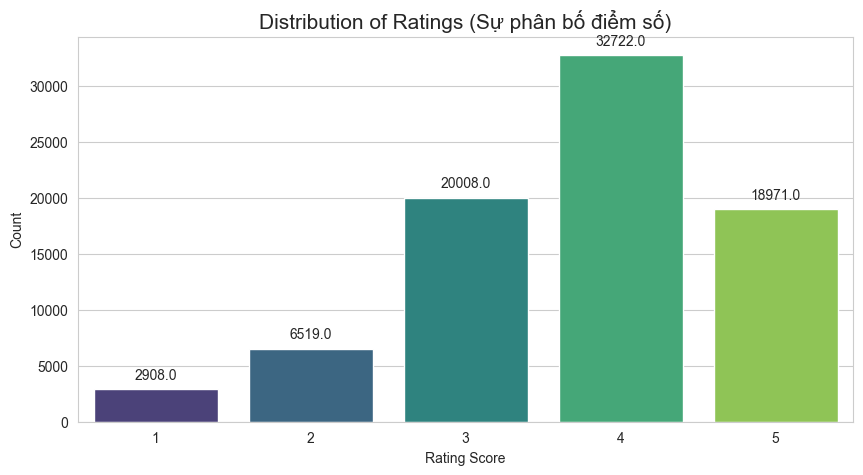

In [75]:
# 3.1 Phân phối Rating (Đánh giá sự mất cân bằng)
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='score', data=ratings_df, palette='viridis')
plt.title('Distribution of Ratings (Sự phân bố điểm số)', fontsize=15)
plt.xlabel('Rating Score')
plt.ylabel('Count')

# Thêm số liệu trên cột
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

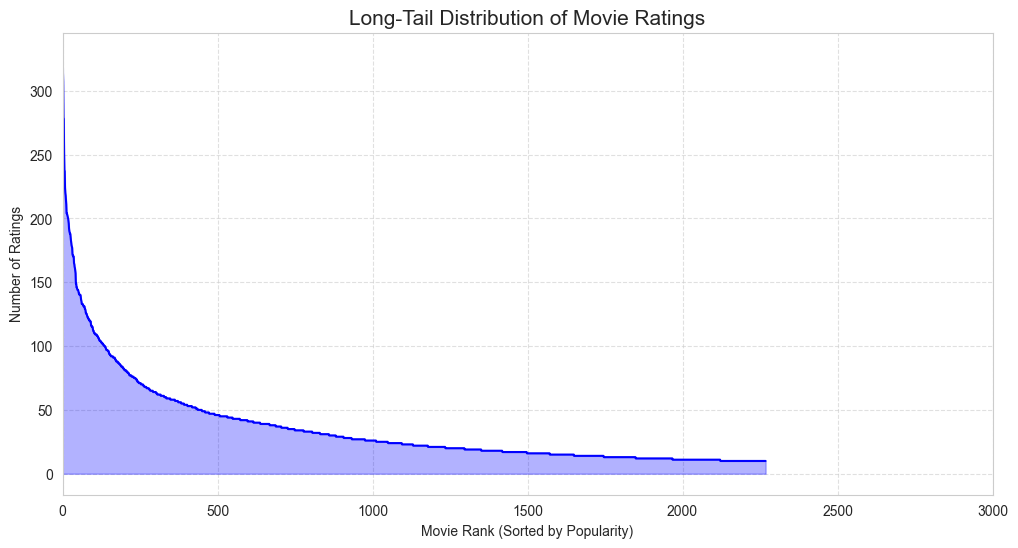

In [76]:
# 3.2 Kiểm tra vấn đề "Long-Tail" (Đuôi dài)
# Hầu hết các lượt đánh giá chỉ tập trung vào một số ít phim nổi tiếng.
movies_count = ratings_df.groupby('movieId').size().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.plot(movies_count.values, color='blue')
plt.title('Long-Tail Distribution of Movie Ratings', fontsize=15)
plt.xlabel('Movie Rank (Sorted by Popularity)')
plt.ylabel('Number of Ratings')
plt.fill_between(range(len(movies_count)), movies_count.values, color='blue', alpha=0.3)
plt.xlim(0, 3000)  # Zoom vào top 3000 phim để thấy rõ hơn
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Long-tail insights
top_5pct = movies_count.head(int(len(movies_count)*0.05))
n_top_5pct = top_5pct.sum()
total = movies_count.sum()


NHÓM 2: PHÂN TÍCH NGƯỜI DÙNG & SỰ TƯƠNG QUAN

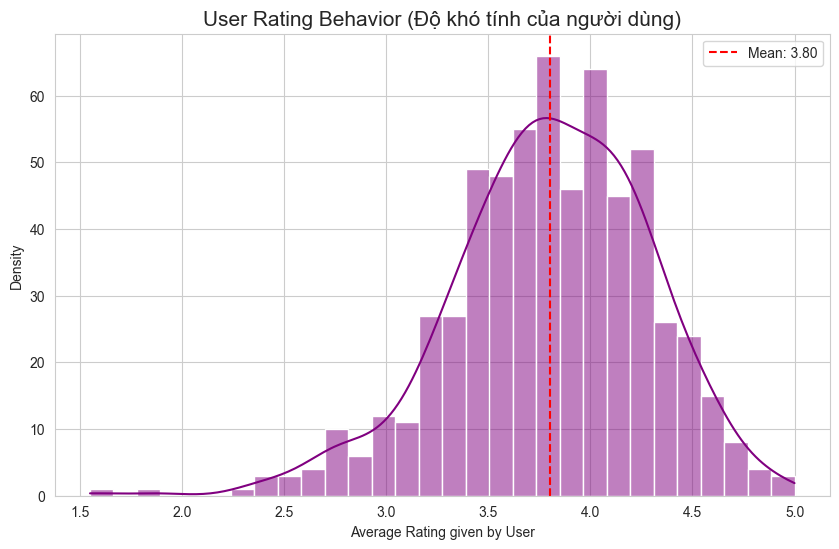

In [77]:
# 3.3 Phân tích hành vi User (User Bias)
# Xem phân phối điểm trung bình mà mỗi user hay cho
user_avg_scores = ratings_df.groupby('userId')['score'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(user_avg_scores, bins=30, kde=True, color='purple')
plt.title('User Rating Behavior (Độ khó tính của người dùng)', fontsize=15)
plt.xlabel('Average Rating given by User')
plt.ylabel('Density')
plt.axvline(user_avg_scores.mean(), color='red', linestyle='--', label=f'Mean: {user_avg_scores.mean():.2f}')
plt.legend()
plt.show()


<Figure size 1000x800 with 0 Axes>

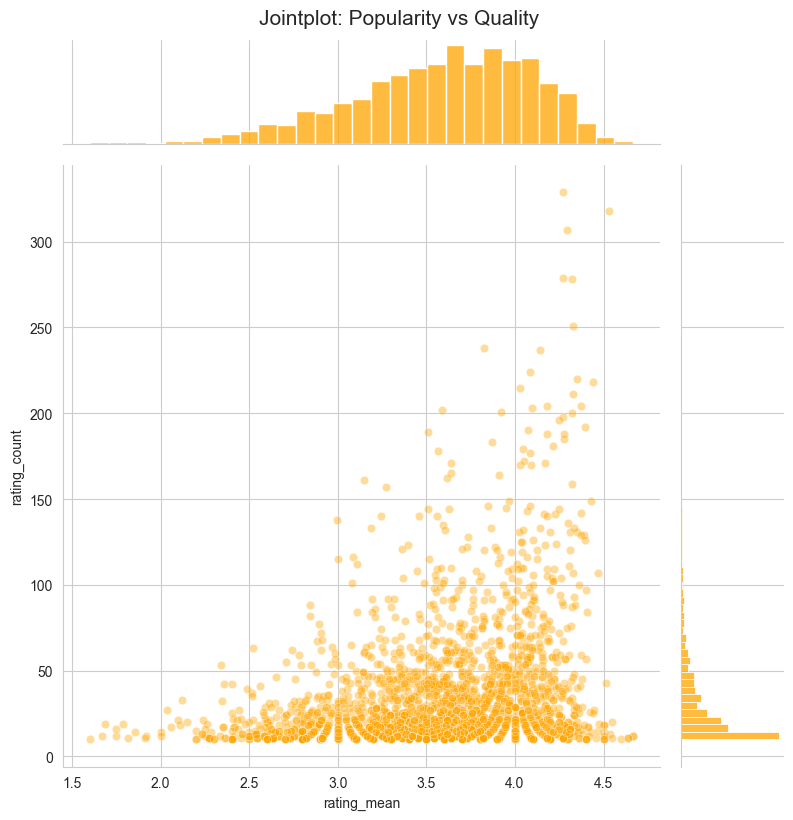

In [78]:
# 3.4 Jointplot: Tương quan giữa Độ nổi tiếng và Chất lượng phim
# Liệu phim nhiều người xem thì điểm có cao không?
movie_stats = ratings_df.groupby('movieId').agg({'score': ['count', 'mean']})
movie_stats.columns = ['rating_count', 'rating_mean']

plt.figure(figsize=(10, 8))
g = sns.jointplot(x='rating_mean', y='rating_count', data=movie_stats, kind='scatter',
                  alpha=0.4, color='orange', height=8)
g.fig.suptitle('Jointplot: Popularity vs Quality', y=1.02, fontsize=15)
plt.show()

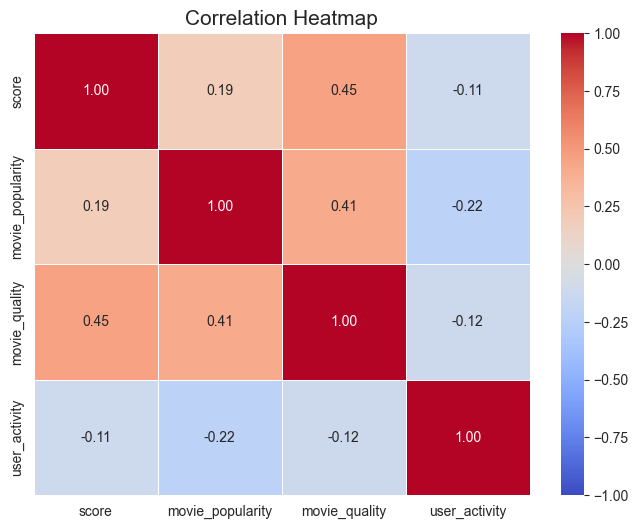

In [80]:
# 3.5 Heatmap Tương quan (Như đã làm, nhưng chuyên nghiệp hơn)
# Gom nhóm dữ liệu
user_activity = ratings_df.groupby('userId')['score'].count()
df_eda = ratings_df.copy()
df_eda['movie_popularity'] = df_eda['movieId'].map(movie_stats['rating_count'])
df_eda['movie_quality'] = df_eda['movieId'].map(movie_stats['rating_mean'])
df_eda['user_activity'] = df_eda['userId'].map(user_activity)

# Tính ma trận tương quan
corr_matrix = df_eda[['score', 'movie_popularity', 'movie_quality', 'user_activity']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap', fontsize=15)
plt.show()

NHÓM 3: PHÂN TÍCH NỘI DUNG & THỂ LOẠI (CONTENT-BASED)


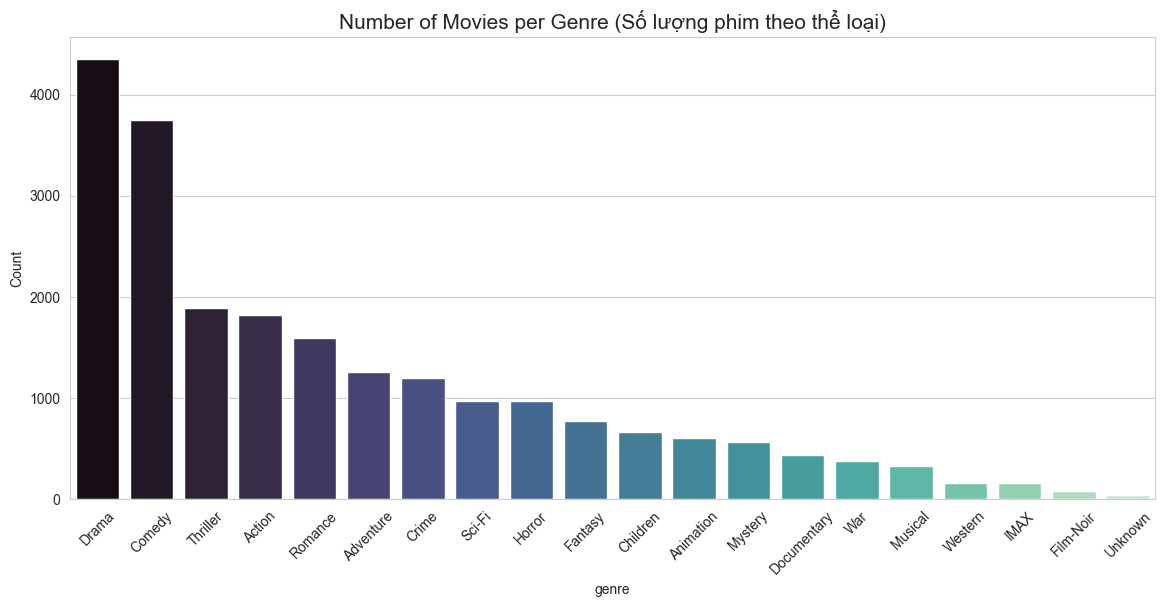

In [81]:
# 3.6 Thể loại nào phổ biến nhất?
# Tách thể loại (Explode)
movies_genres = movies_processed.assign(genre=movies_processed['genres_str'].str.split(' ')).explode('genre')
movies_genres = movies_genres[movies_genres['genre'] != ''] # Bỏ dòng rỗng

# Đếm số lượng phim theo thể loại
genre_counts = movies_genres['genre'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='mako')
plt.title('Number of Movies per Genre (Số lượng phim theo thể loại)', fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

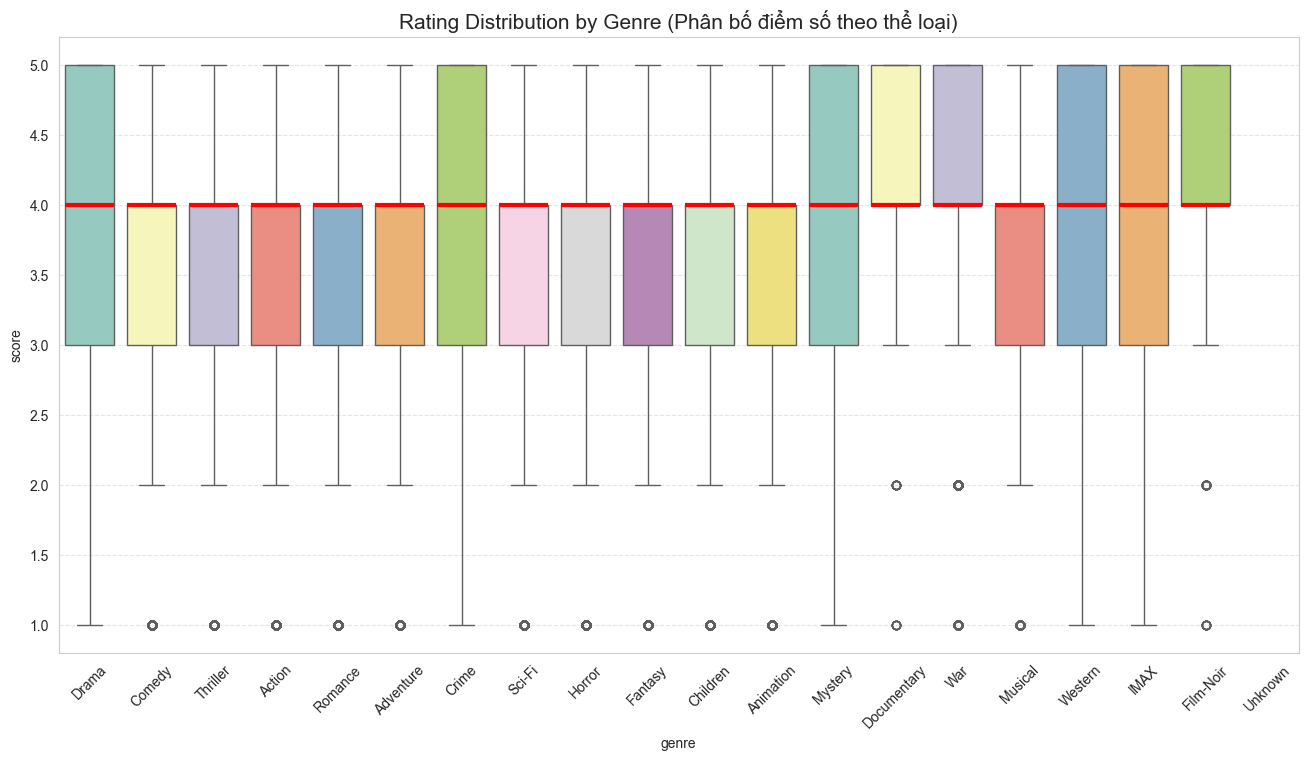

In [82]:
# 3.7 Boxplot: Điểm số trung bình theo Thể loại
# Merge để lấy điểm số cho từng dòng genre
genre_ratings_df = pd.merge(ratings_df, movies_genres[['id', 'genre']], left_on='movieId', right_on='id')

plt.figure(figsize=(16, 8))

# Sử dụng medianprops để định dạng đường trung vị
sns.boxplot(
    x='genre', 
    y='score', 
    data=genre_ratings_df, 
    palette='Set3', 
    order=genre_counts.index,
    medianprops={'color': 'red', 'linewidth': 3} # Làm đường trung vị màu đỏ và dày hơn
)

plt.title('Rating Distribution by Genre (Phân bố điểm số theo thể loại)', fontsize=15)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

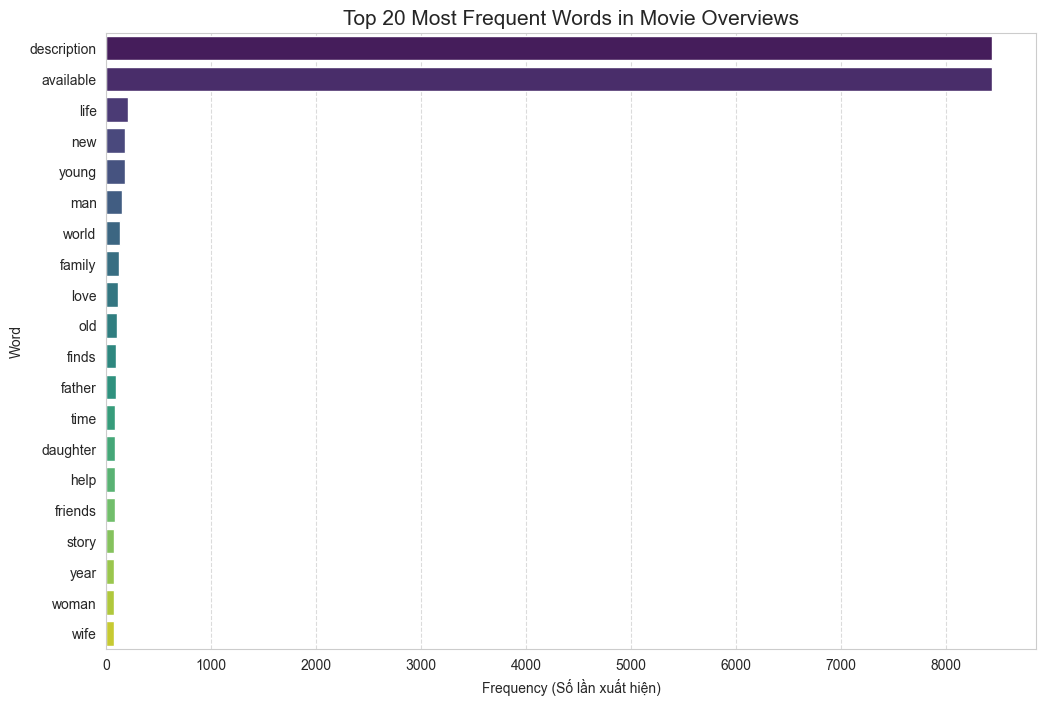

In [83]:
# 3.8 Top 20 Từ khóa phổ biến nhất trong Overview
from sklearn.feature_extraction.text import CountVectorizer

# 1. Lấy dữ liệu text và loại bỏ giá trị null
text_data = movies_processed['overview'].dropna()

# 2. Dùng CountVectorizer để đếm từ (đã loại bỏ stop_words tiếng Anh)
# ngram_range=(1,1) nghĩa là đếm từ đơn.
vectorizer = CountVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(text_data)

# 3. Tính tổng số lần xuất hiện của từng từ
word_counts = X.sum(axis=0)
words_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

# 4. Sắp xếp và lấy Top 20
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:20]
df_words = pd.DataFrame(words_freq, columns=['Word', 'Frequency'])

# 5. Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=df_words, palette='viridis')
plt.title('Top 20 Most Frequent Words in Movie Overviews', fontsize=15)
plt.xlabel('Frequency (Số lần xuất hiện)')
plt.ylabel('Word')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


## 4. Building Collaborative Filtering Model (SVD)
Sử dụng thư viện `Surprise` để xây dựng mô hình Matrix Factorization.
Quy trình:
1. Tuning Hyperparameters (GridSearch).
2. Train model tốt nhất.
3. Đánh giá lỗi (RMSE).

In [84]:
# 4.1 Setup Data for Surprise (Sửa lại để tránh Data Leakage)
from sklearn.model_selection import train_test_split as pd_split

# Bước 1: Chia ratings_df thành 2 phần bằng Pandas
df_dev, df_test = pd_split(ratings_df, test_size=0.2, random_state=42)

# Bước 2: Tạo đối tượng Dataset cho Surprise từ tập df_dev
reader = Reader(rating_scale=(1, 5))
data_tuning = Dataset.load_from_df(df_dev[['userId', 'movieId', 'score']], reader)

# Bước 3: Chuẩn bị tập testset (chuyển sang list tuples để Surprise có thể đọc)
testset = list(df_test.itertuples(index=False, name=None))

print(f"✓ Data prepared.")
print(f"  - Tập Tuning/Train: {len(df_dev)} dòng")
print(f"  - Tập Test hoàn toàn độc lập: {len(df_test)} dòng")

✓ Data prepared.
  - Tập Tuning/Train: 64902 dòng
  - Tập Test hoàn toàn độc lập: 16226 dòng


In [85]:
# 4.2 Hyperparameter Tuning (Sửa: Chỉ chạy trên data_tuning)

param_grid = {
    'n_factors': [50, 100], 
    'n_epochs': [20, 30],       
    'lr_all': [0.005, 0.01],    
    'reg_all': [0.02, 0.1]      
}

print(" Starting GridSearchCV on Training Set only...")
# Dùng data_tuning thay vì data
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
gs.fit(data_tuning) 

print("\n Best RMSE score:", gs.best_score['rmse'])
print(" Best parameters:", gs.best_params['rmse'])

# Gán model tốt nhất
best_svd = gs.best_estimator['rmse']

 Starting GridSearchCV on Training Set only...

 Best RMSE score: 0.8503746151660057
 Best parameters: {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}


In [86]:
# 4.3 Train & Evaluate on Test Set
print("Training best model on the Development Set (80%)...")

# BƯỚC QUAN TRỌNG: 
# Chuyển đổi data_tuning (Dataset) thành trainset (Trainset object) để mô hình có thể fit.
# Lưu ý: train trên toàn bộ 80% dữ liệu đã dùng để tuning.
trainset_to_eval = data_tuning.build_full_trainset()
best_svd.fit(trainset_to_eval)

print("Predicting on the Independent Test Set (20%)...")
# testset ở đây chính là list tuples (userId, movieId, score) 
# mà chúng ta đã tách riêng ra bằng Pandas ở bước 4.1
predictions = best_svd.test(testset)

# Tính độ chính xác
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"\n Model Evaluation Finished.")
print(f"   RMSE: {rmse:.4f} (Độ lệch trung bình điểm số)")
print(f"   MAE:  {mae:.4f} (Sai số tuyệt đối trung bình)")

Training best model on the Development Set (80%)...
Predicting on the Independent Test Set (20%)...
RMSE: 0.8486
MAE:  0.6572

 Model Evaluation Finished.
   RMSE: 0.8486 (Độ lệch trung bình điểm số)
   MAE:  0.6572 (Sai số tuyệt đối trung bình)


In [87]:
# 4.4 Train on 80% Data & Save (Lưu vào models/)
print("Training on 80% Development Data for Production...")

# Tạo thư mục models/ nếu chưa có
if not os.path.exists('models'):
    os.makedirs('models')

# Sử dụng bộ tham số tốt nhất tìm được từ GridSearch
# Nhưng chỉ huấn luyện trên tập trainset_to_eval (80% dữ liệu)
production_svd = SVD(**gs.best_params['rmse'])
production_svd.fit(trainset_to_eval) 

# Lưu model vào folder models/ (ĐỒNG BỘ VỚI MAIN.PY)
model_filename = 'models/svd_model_v1.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(production_svd, f)

print(f"✅ SVD Model saved to {model_filename}")
print(f"✅ Model này chỉ học từ 80% dữ liệu ({len(df_dev)} ratings).")
print(f"📁 File sẵn sàng để deploy lên FastAPI server!")

Training on 80% Development Data for Production...
✅ SVD Model saved to models/svd_model_v1.pkl
✅ Model này chỉ học từ 80% dữ liệu (64902 ratings).
📁 File sẵn sàng để deploy lên FastAPI server!


## 5. Building Content-Based Model (TF-IDF)
Mô hình này giúp gợi ý các phim "tương tự" dựa trên nội dung (Overview + Genre) để giải quyết vấn đề Cold-Start (phim mới chưa có rating).

In [88]:
# 5.1 Chuẩn bị dữ liệu cho Content-Based Filtering (Đã tối ưu)
df_content = movies_processed.copy()

if 'content_features' not in df_content.columns:
    print(" Cảnh báo: content_features chưa được tạo. Đang tạo mới...")
    # fillna('') là bắt buộc để TF-IDF không bị lỗi
    df_content['content_features'] = df_content['overview'].fillna('') + ' ' + df_content['genres_str'].fillna('')
else:
    print("✓ Sử dụng content_features đã được làm sạch từ bước Preprocessing")
    # Đảm bảo không có dòng nào bị NaN do sơ suất
    df_content['content_features'] = df_content['content_features'].fillna('')

print(f"\n Tổng số phim trong kho: {len(df_content)}")

✓ Sử dụng content_features đã được làm sạch từ bước Preprocessing

 Tổng số phim trong kho: 9724


In [89]:
# 5.2 Vector hóa văn bản (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer

# Sử dụng content_features đã clean
tfidf = TfidfVectorizer(
    stop_words='english',
    min_df=3,
    max_features=5000,
    ngram_range=(1, 2)  # THÊM: Để bắt được các cụm từ như "science fiction"
)

# Đảm bảo không có NaN và dữ liệu là chuỗi
tfidf_matrix = tfidf.fit_transform(df_content['content_features'].values.astype('U'))
print(f" TF-IDF Matrix shape: {tfidf_matrix.shape}")
print(f"   - Số phim: {tfidf_matrix.shape[0]:,}")
print(f"   - Số features (từ vựng): {tfidf_matrix.shape[1]:,}")
print(f"   - Độ thưa (sparsity): {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%")
print(f"   - Dung lượng ước tính: {tfidf_matrix.data.nbytes / (1024**2):.2f} MB")

 TF-IDF Matrix shape: (9724, 2963)
   - Số phim: 9,724
   - Số features (từ vựng): 2,963
   - Độ thưa (sparsity): 99.69%
   - Dung lượng ước tính: 0.69 MB


In [91]:
# 5.3 Lưu các tài nguyên Content-Based
if not os.path.exists('models'):
    os.makedirs('models')

# Lưu Matrix (dạng sparse để tiết kiệm bộ nhớ)
scipy.sparse.save_npz('models/tfidf_matrix.npz', tfidf_matrix)

# Lưu Vectorizer (để xử lý phim mới sau này)
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Lưu DataFrame ánh xạ ID (để tra cứu)
df_content[['id', 'title']].to_pickle('models/movie_map.pkl')

print(" All Content-Based assets saved successfully into 'models/' folder.")

 All Content-Based assets saved successfully into 'models/' folder.


# 6. Conclusion & Next Steps
Notebook đã hoàn thành quy trình xây dựng hệ thống gợi ý chuyên sâu:
1. **Dữ liệu sạch:** Kết nối và xử lý dữ liệu từ Database, loại bỏ nhiễu (phim < 10 ratings, user < 5 ratings).
2. **Phân tích hành vi (EDA):** Xác định hiện tượng Long-tail và sự phân bổ đánh giá của người dùng.
3. **Mô hình Collaborative Filtering (SVD):** Đã tối ưu hóa qua GridSearchCV, đạt RMSE **0.85** (mức độ chính xác cao đối với dữ liệu MovieLens).
4. **Mô hình Content-Based (TF-IDF):** Xây dựng thành công dựa trên Overview và Genre để giải quyết vấn đề Cold Start cho phim mới.
5. **Đóng gói:** Xuất model và mapping dictionary ra file `.pkl`, sẵn sàng tích hợp vào API FastAPI.